In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration

In [4]:
# Load the data
df = pd.read_csv('../data/retail_store_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [15]:
# List down column names
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

Breakdown of columns for this demand forecasting exploration:
- 'Units Sold': target variable
- 'Date' & 'Product ID': unique identifier while aggregating across stores, category, region
  - Ignore: 'Store ID', 'Category', 'Region'
- Covariate:
    - 'Weather Condition': past --> [ALPS]: weather 
    - 'Holiday/Promotion': future --> [ALPS]: Public Holiday, Subsidy Policy
    - 'Seasonality': future --> [ALPS]: 4 season or flu season 
    - Calender information: add_encoder
    - Public holiday: https://github.com/dr-prodigy/python-holidays
- Drop correlated columns: 'Inventory Level', 'Units Ordered', 'Demand Forecast'
- Drop less relevant covariates: 'Price', 'Discount', 'Competitor Pricing'

## Data Preprocessing

In [5]:
# Drop irrelevant columns
df.drop(['Store ID', 'Category', 'Region', 'Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing'], axis=1, inplace=True)
df.head()

,Date,Product ID,Units Sold,Weather Condition,Holiday/Promotion,Seasonality
0,2022-01-01,P0001,127,Rainy,0,Autumn
1,2022-01-01,P0002,150,Sunny,0,Autumn
2,2022-01-01,P0003,65,Sunny,1,Summer
3,2022-01-01,P0004,61,Cloudy,1,Autumn
4,2022-01-01,P0005,14,Sunny,0,Summer


Aggregate data across stores & on weekly basis:
- Units Sold → Sum
- Weather Condition → Mode (most frequent value)
- Holiday/Promotion → Max (to capture any occurrence)
- Seasonality → Mode (most frequent seasonal label)

In [6]:
# Aggregate across all stores/ regions/ categories
aggregated_df = df.groupby(['Date', 'Product ID']).agg({ # Keep unique Date and Product ID pairs
    'Units Sold': 'sum',
    'Weather Condition': lambda x: x.mode()[0] if not x.mode().empty else None,  # Mode
    'Holiday/Promotion': 'max',  # If any promotion/holiday exists, it is recorded
    'Seasonality': lambda x: x.mode()[0] if not x.mode().empty else None  # Mode
}).reset_index()
aggregated_df.head()

,Date,Product ID,Units Sold,Weather Condition,Holiday/Promotion,Seasonality
0,2022-01-01,P0001,726,Sunny,1,Winter
1,2022-01-01,P0002,773,Sunny,1,Autumn
2,2022-01-01,P0003,732,Sunny,1,Spring
3,2022-01-01,P0004,455,Cloudy,1,Autumn
4,2022-01-01,P0005,716,Rainy,1,Winter


In [7]:
# Aggregate on weekly baisis
aggregated_df['Week'] = aggregated_df['Date'].dt.to_period('W').astype(str)  # Create a 'Week' column based on the ISO calendar week

weekly_aggregated_df = aggregated_df.groupby(['Week', 'Product ID']).agg({
    'Units Sold': 'sum',
    'Weather Condition': lambda x: x.mode()[0] if not x.mode().empty else None,  # Mode
    'Holiday/Promotion': 'max',  # If any promotion/holiday exists, it is recorded
    'Seasonality': lambda x: x.mode()[0] if not x.mode().empty else None  # Mode
}).reset_index()
weekly_aggregated_df.head()

,Week,Product ID,Units Sold,Weather Condition,Holiday/Promotion,Seasonality
0,2021-12-27/2022-01-02,P0001,1353,Cloudy,1,Autumn
1,2021-12-27/2022-01-02,P0002,1069,Rainy,1,Autumn
2,2021-12-27/2022-01-02,P0003,1782,Snowy,1,Autumn
3,2021-12-27/2022-01-02,P0004,978,Cloudy,1,Autumn
4,2021-12-27/2022-01-02,P0005,1431,Cloudy,1,Autumn


In [8]:
# Reformat the 'Week' column
weekly_aggregated_df['Week'] = pd.to_datetime(weekly_aggregated_df['Week'].str.split('/').str[0])  # Takes the first date of the week
weekly_aggregated_df = weekly_aggregated_df.sort_values(by=['Product ID', 'Week']) # Sort for consistency

# Encoding categorical variables as numerical for Darts
weekly_aggregated_df['Weather Condition'] = weekly_aggregated_df['Weather Condition'].astype('category').cat.codes
weekly_aggregated_df['Seasonality'] = weekly_aggregated_df['Seasonality'].astype('category').cat.codes
weekly_aggregated_df.head()

,Week,Product ID,Units Sold,Weather Condition,Holiday/Promotion,Seasonality
0,2021-12-27,P0001,1353,0,1,0
20,2022-01-03,P0001,4606,1,1,2
40,2022-01-10,P0001,3557,1,1,3
60,2022-01-17,P0001,4920,1,1,1
80,2022-01-24,P0001,5003,2,1,0


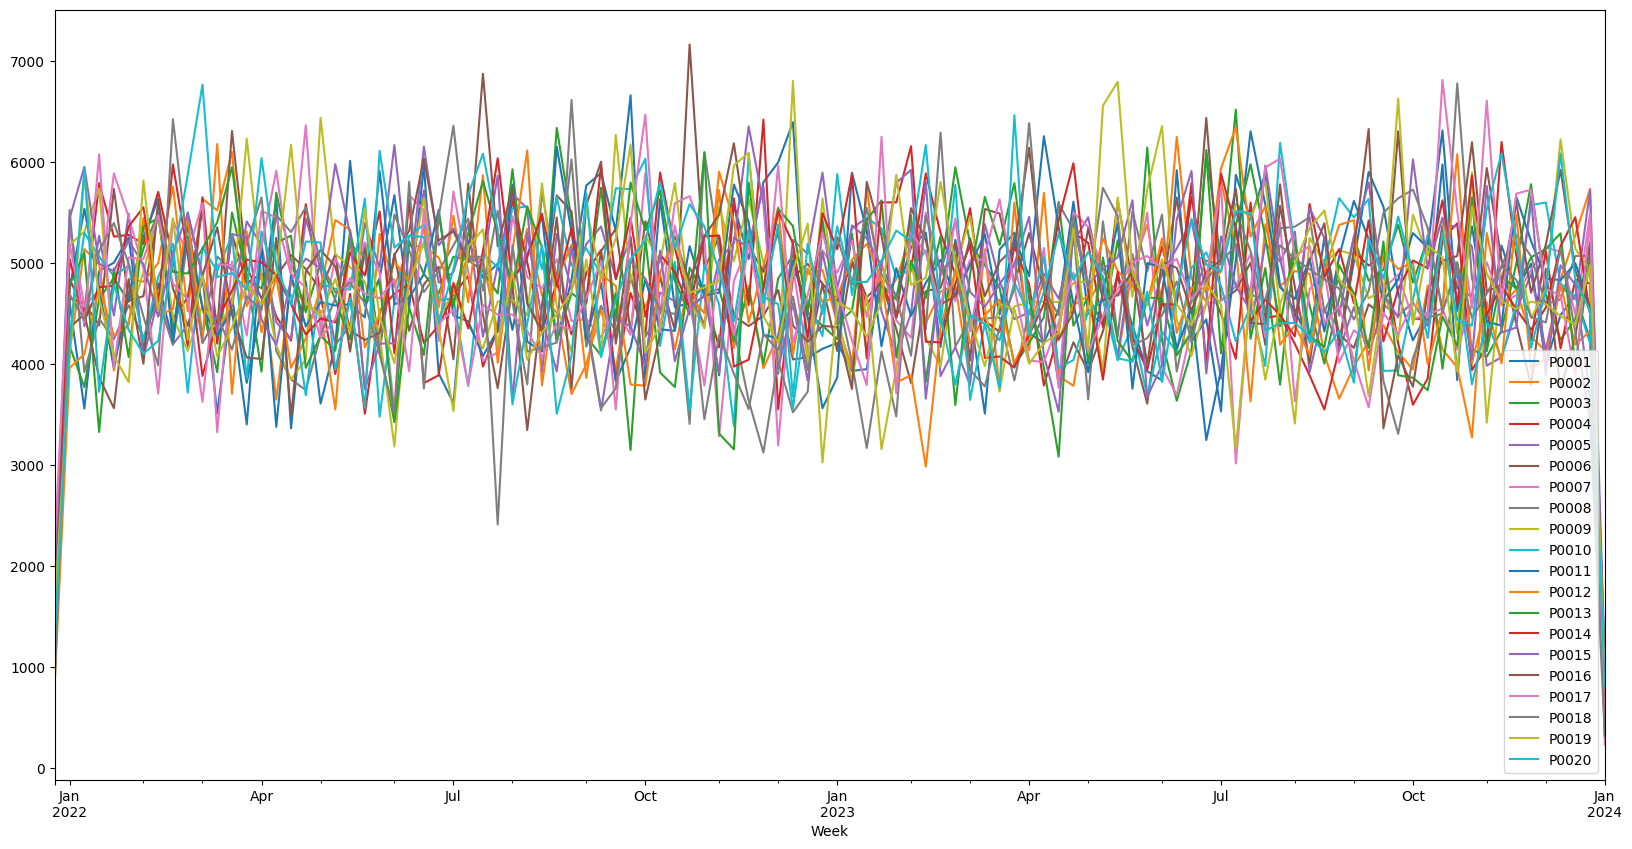

In [8]:
# plot units sold of each product on a diagram using weekly_aggreated_df
fig, ax = plt.subplots(figsize=(20, 10))
for key, grp in weekly_aggregated_df.groupby('Product ID'):
    ax = grp.plot(ax=ax, kind='line', x='Week', y='Units Sold', label=key)
plt.show()

## Time Series Analysis

In [9]:
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_acf, plot_pacf
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import RandomForest
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape, mae, rmse, r2_score
from darts.timeseries import concatenate
import torch

For ARIMA, Prophet, DeepAR, only future covariate is accepted.

In [8]:
# Reformat into Darts TimeSeries objects & Split into train/test sets

df = weekly_aggregated_df

# Train-test split based on forecast horizon
forecast_horizon = 20  # Forecast for the next 4 weeks
last_valid_time = df.set_index("Week")['Weather Condition'].last_valid_index() # Find the last available timestamp for future covariates
split_point = last_valid_time - pd.Timedelta(weeks=forecast_horizon)  # Compute the train-test split point (Leave `forecast_horizon` weeks for testing)
print(f"Split point: {split_point}")

target_series_dict = {}  # 'Units Sold'
future_covariates_dict = {}  # 'Weather Condition', 'Holiday/Promotion', 'Seasonality'

# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
future_covariates_list = []
product_id_list = []

for product_id in df['Product ID'].unique():
    product_id_list.append(product_id)
    df_product = df[df['Product ID'] == product_id] # Select relevant rows for the product
    df_product = df_product.set_index('Week') # Set week as index
    
    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_product, value_cols=['Units Sold'])
    future_covariates = TimeSeries.from_dataframe(df_product, 
                                                  value_cols=['Weather Condition', 'Holiday/Promotion', 'Seasonality'])
    
    train_series, test_series = target_series.split_after(split_point)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series.astype(np.float32))
    test_series_list.append(test_series.astype(np.float32))
    future_covariates_list.append(future_covariates.astype(np.float32))

Split point: 2023-08-14 00:00:00


For TCN and N-BEATS, only past covariates are supported

In [9]:
# Reformat into Darts TimeSeries objects & Split into train/test sets

df = weekly_aggregated_df

# Train-test split based on forecast horizon
forecast_horizon = 20  # Forecast for the next 4 weeks
last_valid_time = df.set_index("Week")['Weather Condition'].last_valid_index() # Find the last available timestamp for future covariates
split_point = last_valid_time - pd.Timedelta(weeks=forecast_horizon)  # Compute the train-test split point (Leave `forecast_horizon` weeks for testing)
print(f"Split point: {split_point}")

target_series_dict = {}  # 'Units Sold'
past_covariates_dict = {}  # 'Weather Condition', 'Holiday/Promotion', 'Seasonality'

# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
past_covariates_list = []
product_id_list = []

for product_id in df['Product ID'].unique():
    product_id_list.append(product_id)
    df_product = df[df['Product ID'] == product_id] # Select relevant rows for the product
    df_product = df_product.set_index('Week') # Set week as index
    
    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_product, value_cols=['Units Sold'])
    past_covariates = TimeSeries.from_dataframe(df_product, 
                                                  value_cols=['Weather Condition', 'Holiday/Promotion', 'Seasonality'])
    
    train_series, test_series = target_series.split_after(split_point)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series.astype(np.float32))
    test_series_list.append(test_series.astype(np.float32))
    past_covariates_list.append(past_covariates.astype(np.float32))

Split point: 2023-08-14 00:00:00


For Regression model, both past and future covariates are supported

In [10]:
# Reformat into Darts TimeSeries objects & Split into train/test sets

df = weekly_aggregated_df

# Train-test split based on forecast horizon
forecast_horizon = 20  # Forecast for the next 4 weeks
last_valid_time = df.set_index("Week")['Weather Condition'].last_valid_index() # Find the last available timestamp for future covariates
split_point = last_valid_time - pd.Timedelta(weeks=forecast_horizon)  # Compute the train-test split point (Leave `forecast_horizon` weeks for testing)
print(f"Split point: {split_point}")

target_series_dict = {}  # 'Units Sold'
past_covariates_dict = {}  # 'Weather Condition'
future_covariates_dict = {} # 'Holiday/Promotion', 'Seasonality'

# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
past_covariates_list = []
future_covariates_list = []
product_id_list = []

for product_id in df['Product ID'].unique():
    product_id_list.append(product_id)
    df_product = df[df['Product ID'] == product_id] # Select relevant rows for the product
    df_product = df_product.set_index('Week') # Set week as index
    
    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_product, value_cols=['Units Sold'])
    past_covariates = TimeSeries.from_dataframe(df_product, 
                                                  value_cols=['Weather Condition'])
    future_covariates = TimeSeries.from_dataframe(df_product, 
                                                  value_cols=['Holiday/Promotion', 'Seasonality'])
    
    train_series, test_series = target_series.split_after(split_point)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series.astype(np.float32))
    test_series_list.append(test_series.astype(np.float32))
    past_covariates_list.append(past_covariates.astype(np.float32))
    future_covariates_list.append(future_covariates.astype(np.float32))

Split point: 2023-08-14 00:00:00


In [11]:
add_encoders = {
    'cyclic': {'future': ['month']},   # this will add sin/cos month features
    'datetime_attribute': {'future': ['year', 'month', 'weekofyear']},  # optional, if you also want year, week etc.
}

In [11]:
print(len(train_series_list))
print(len(train_series_list[0]))
print(len(test_series_list))
print(len(test_series_list[0]))


20
86
20
20


<Axes: xlabel='Week'>

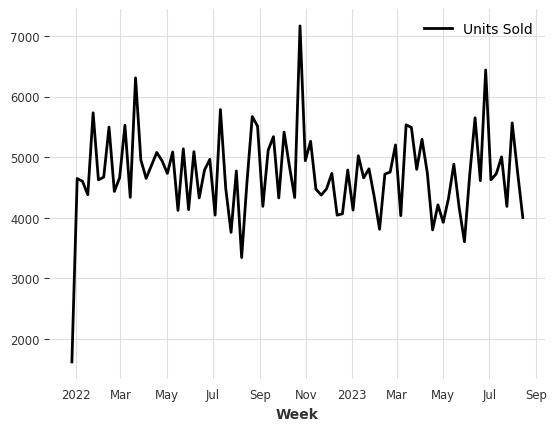

In [39]:
train_series_list[5].plot()

<Axes: xlabel='Week'>

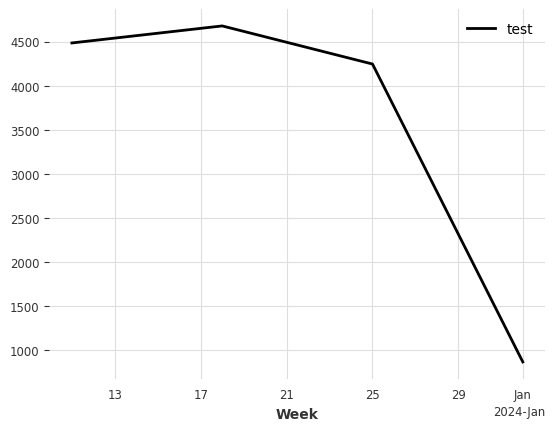

In [30]:
test_series_list[0].plot(label='test')

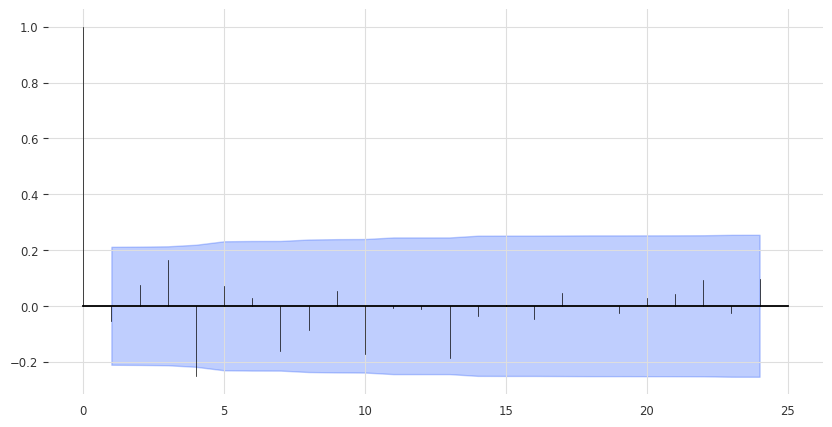

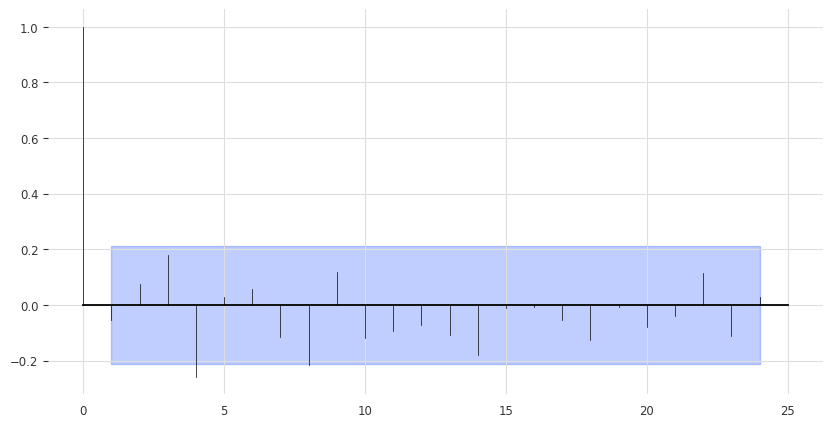

In [53]:
series = train_series_list[5]
plot_acf(series)
plot_pacf(series)

In [54]:
from darts.utils.statistics import check_seasonality, stationarity_test_adf, stationarity_tests
#check_seasonality(series) 
# stationarity_test_adf(series)
stationarity_tests(series)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/darts/utils/statistics.py:463: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


True

Creation of training data
- input_chunk_length
- training_length
- If training_length=24 and input_chunk_length=12, then:
	•	The model takes 12 past time steps as input (input_chunk_length).
	•	It then makes predictions iteratively over the next 12 steps, making a total of 24 steps in the training sequence.

In [56]:
# Scale target & covariates to improve training
# Use separate scalers for target (Units Sold) and future covariates (since they have different distributions)
target_scaler = Scaler()
future_covariates_scaler = Scaler()

# Fit only on the training set, then transform train & test sets -- so the model does not see future information while scaling
train_series_scaled = [target_scaler.fit_transform(ts) for ts in train_series_list]
test_series_scaled = [target_scaler.transform(ts) for ts in test_series_list]  

future_covariates_scaled = [future_covariates_scaler.fit_transform(ts) for ts in future_covariates_list]

In [12]:
# Scale target & covariates to improve training
# Use separate scalers for target (Units Sold) and future covariates (since they have different distributions)
target_scaler = Scaler()
past_covariates_scaler = Scaler()

# Fit only on the training set, then transform train & test sets -- so the model does not see future information while scaling
train_series_scaled = [target_scaler.fit_transform(ts) for ts in train_series_list]
test_series_scaled = [target_scaler.transform(ts) for ts in test_series_list]  

past_covariates_scaled = [past_covariates_scaler.fit_transform(ts) for ts in past_covariates_list]

In [12]:
# Scale target & covariates to improve training
# Use separate scalers for target (Units Sold) and future covariates (since they have different distributions)
target_scaler = Scaler()
past_covariates_scaler = Scaler()
future_covariates_scaler = Scaler()

# Fit only on the training set, then transform train & test sets -- so the model does not see future information while scaling
train_series_scaled = [target_scaler.fit_transform(ts) for ts in train_series_list]
test_series_scaled = [target_scaler.transform(ts) for ts in test_series_list]  

past_covariates_scaled = [past_covariates_scaler.fit_transform(ts) for ts in past_covariates_list]
future_covariates_scaled = [future_covariates_scaler.fit_transform(ts) for ts in future_covariates_list]

## Model

### Statistical Model
Only local models available, fit one model per product

#### ARIMA

In [ ]:
from darts.models import ARIMA

models = []

for series, covariates in zip(train_series_scaled, future_covariates_scaled):
    model = ARIMA(
    add_encoders=add_encoders
    )
    model.fit(series, future_covariates=covariates)
    models.append(model)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

In [59]:
forecast_horizon = 4

model = models[0]
future_covs = future_covariates_scaled[0]

pred = model.predict(n=forecast_horizon, 
                    future_covariates=future_covs)
print(pred)

<TimeSeries (DataArray) (Week: 4, component: 1, sample: 1)> Size: 32B
array([[[0.5955729 ]],

       [[0.71389419]],

       [[0.64830572]],

       [[0.63742927]]])
Coordinates:
  * Week       (Week) datetime64[ns] 32B 2023-08-21 2023-08-28 ... 2023-09-11
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


#### Prophet

In [25]:
from darts.models import Prophet

models = []

custom_seasonality = {
    'name': 'monthly',
    'seasonal_periods': 4.33,   # Monthly for weekly data
    'fourier_order': 5,  # Start with 5–10. Higher = more flexible.
}

for series, covariates in zip(train_series_scaled, future_covariates_scaled):
    model = Prophet(
        add_seasonalities=[custom_seasonality],
        country_holidays="SG",  # Singapore holidays
        add_encoders=add_encoders
    )
    model.fit(series, future_covariates=covariates)
    models.append(model)

12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:05 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1] done processing
12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:06 - cmdstanpy - INFO - Chain [1]

In [26]:
forecast_horizon = 4

model = models[0]
future_covs = future_covariates_scaled[0]

pred = model.predict(n=forecast_horizon, 
                    future_covariates=future_covs)
print(pred)

<TimeSeries (DataArray) (Week: 4, component: 1, sample: 1)> Size: 32B
array([[[0.71582954]],

       [[0.77262164]],

       [[0.82111922]],

       [[0.82584262]]])
Coordinates:
  * Week       (Week) datetime64[ns] 32B 2023-08-21 2023-08-28 ... 2023-09-11
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


### Regression
- XGBoost & LightGBM: kernel crashed
- LinearRegression: ☑️
- Random Forest: ☑️

In [ ]:
model = RandomForest(
    lags=4,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3],
    output_chunk_length=1,
    add_encoders=add_encoders
)
model.fit(series=train_series_scaled, 
          past_covariates=past_covariates_scaled, 
          future_covariates=future_covariates_scaled)

RandomForest(lags=3, lags_past_covariates=12, lags_future_covariates=[0, 1, 2, 3], output_chunk_length=1, output_chunk_shift=0, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['year', 'month', 'weekofyear']}}, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True)

In [17]:
forecast_horizon = 4
pred = model.predict(n=forecast_horizon, 
                    series=train_series_scaled,
                    past_covariates=past_covariates_scaled,
                    future_covariates=future_covariates_scaled)
print(pred[0])

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<TimeSeries (DataArray) (Week: 4, component: 1, sample: 1)> Size: 32B
array([[[0.68199056]],

       [[0.64830593]],

       [[0.68659697]],

       [[0.67009419]]])
Coordinates:
  * Week       (Week) datetime64[ns] 32B 2023-08-21 2023-08-28 ... 2023-09-11
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


### TCN

In [14]:
model = TCNModel(
    input_chunk_length=12,
    output_chunk_length=4,
    add_encoders=add_encoders
)
model.fit(series=train_series_scaled, 
          past_covariates=past_covariates_scaled, 
          verbose=True)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 104    | train
-------------------------------------------------------------
104       Trainable params
0         Non-trainable params
104       Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=12, output_chunk_length=4, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['year', 'month', 'weekofyear']}})

In [ ]:
forecast_horizon = 4
pred = model.predict(n=forecast_horizon, 
                    series=train_series_scaled,
                    past_covariates=past_covariates_scaled)
print(pred[0])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Week: 4, component: 1, sample: 1)> Size: 16B
array([[[0.68889683]],

       [[0.6640804 ]],

       [[0.66547984]],

       [[0.66740495]]], dtype=float32)
Coordinates:
  * Week       (Week) datetime64[ns] 32B 2023-08-21 2023-08-28 ... 2023-09-11
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


### N-BEATs
NHiTS implementation currently does not support MPS (GPU for Mac)

In [ ]:
model = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=4,
    add_encoders=add_encoders, 
    n_epochs=20, # very slow to train
)
model.fit(series=train_series_scaled, 
          past_covariates=past_covariates_scaled, 
          verbose=True)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.785    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=12, output_chunk_length=4, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['year', 'month', 'weekofyear']}}, n_epochs=20)

In [24]:
forecast_horizon = 4
pred = model.predict(n=forecast_horizon, 
                    series=train_series_scaled,
                    past_covariates=past_covariates_scaled)
print(pred[0])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Week: 4, component: 1, sample: 1)> Size: 16B
array([[[0.65631115]],

       [[0.70855343]],

       [[0.8061616 ]],

       [[0.63242036]]], dtype=float32)
Coordinates:
  * Week       (Week) datetime64[ns] 32B 2023-08-21 2023-08-28 ... 2023-09-11
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


### DeepAR

In [ ]:
# Define DeepAR model (Probabilistic RNN)
model = RNNModel(
    model="LSTM",              # Use LSTM 
    input_chunk_length=12,     # Lookback window (12 weeks)
    training_length=16,        # Training sequence length (12+4: to predict next month)
    hidden_dim=25,             # RNN hidden units # 50
    n_rnn_layers=2,            # Number of LSTM layers
    dropout=0.1,               # Regularization
    batch_size=16,             # Batch size for training # 32
    n_epochs=50,              # Number of training epochs # 100
    optimizer_kwargs={"lr": 1e-3},  # Learning rate
    random_state=42,
    likelihood=GaussianLikelihood(),     # Probabilistic output (DeepAR uses Gaussian likelihood)
    add_encoders=add_encoders, # Add time features
    # pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}  # Switch to Google Colab for GPU
)

# Fit the model
model.fit(series=train_series_scaled, 
          future_covariates=future_covariates_scaled, 
          verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.8 K  | train
6 | V               | Linear           | 52     | train
-------------------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.035     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.1, training_length=24, input_chunk_length=12, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.001}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['year', 'month', 'weekofyear']}})

In [13]:
# Forecasting
forecast_horizon = 20  # Predict next 4 weeks

# Generate probabilistic forecasts
predictions = model.predict(n=forecast_horizon, 
                            series=train_series_scaled, # Forecast multiple series
                            num_samples=1,  # Monte Carlo sampling for uncertainty estimation
                            future_covariates=future_covariates_scaled)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
# Inverse scaling for the predictions
predictions_scaled_back = [target_scaler.inverse_transform(ts) for ts in predictions]  

In [15]:
# Visualize the predictions
print(test_series_list[0])
print(predictions_scaled_back[0])

<TimeSeries (DataArray) (Week: 20, component: 1, sample: 1)> Size: 80B
array([[[5256.]],

       [[4180.]],

       [[5014.]],

       [[5902.]],

       [[5557.]],

       [[4692.]],

       [[4234.]],

       [[4512.]],

       [[5976.]],

       [[3840.]],

       [[5629.]],

       [[4195.]],

       [[5173.]],

       [[4730.]],

       [[4992.]],

       [[4004.]],

       [[4484.]],

       [[4677.]],

       [[4245.]],

       [[ 869.]]], dtype=float32)
Coordinates:
  * Week       (Week) datetime64[ns] 160B 2023-08-21 2023-08-28 ... 2024-01-01
  * component  (component) object 8B 'Units Sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (Week: 20, component: 1, sample: 1)> Size: 80B
array([[[5207.369 ]],

       [[3404.1638]],

       [[2579.5608]],

       [[4996.847 ]],

       [[3319.9602]],

       [[2645.4104]],

       [[2947.4514]],

       [[4917.265 ]],

       [[3173.67  ]],

     

In [16]:
# Calculate metric for each product
metrics_results = []

for product_id, actual, predicted in zip(product_id_list, test_series_list, predictions_scaled_back):
    mape_score = mape(actual, predicted)
    # mae_score = mae(actual, predicted)
    # rmse_score = rmse(actual, predicted)
    # r2 = r2_score(actual, predicted)

    metrics_results.append({
        "Product ID": product_id,
        "MAPE": mape_score,
        # "MAE": mae_score,
        # "RMSE": rmse_score,
        # "R²": r2
    })

metrics_df = pd.DataFrame(metrics_results)
print(metrics_df)

   Product ID        MAPE
0       P0001   43.590076
1       P0002   60.470074
2       P0003  101.634872
3       P0004   78.730667
4       P0005   25.847332
5       P0006   37.004662
6       P0007  136.952271
7       P0008   38.393005
8       P0009   76.595932
9       P0010   28.502893
10      P0011   84.909592
11      P0012   42.798370
12      P0013   51.038883
13      P0014   41.798378
14      P0015   30.655798
15      P0016   51.333153
16      P0017   80.326515
17      P0018   58.880043
18      P0019   32.041744
19      P0020   43.139977


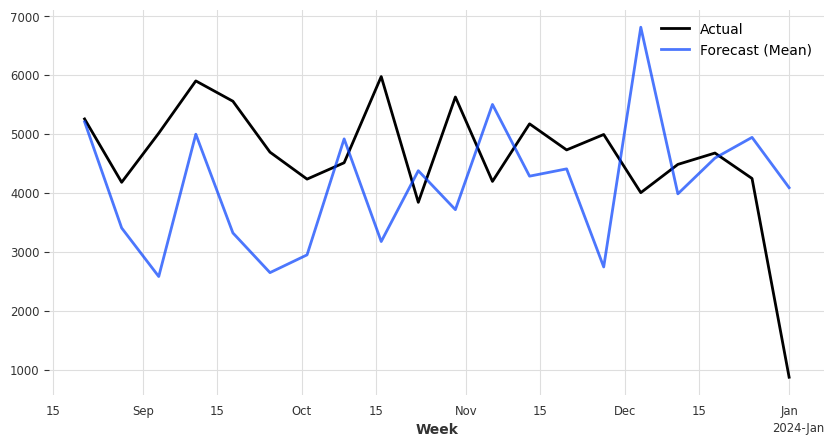

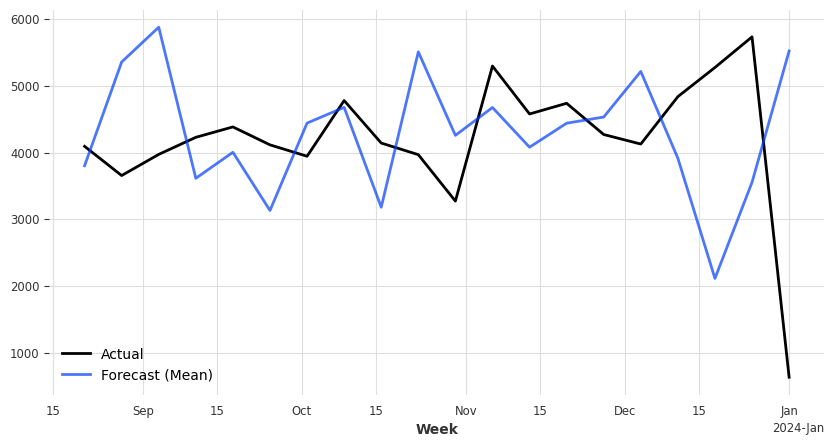

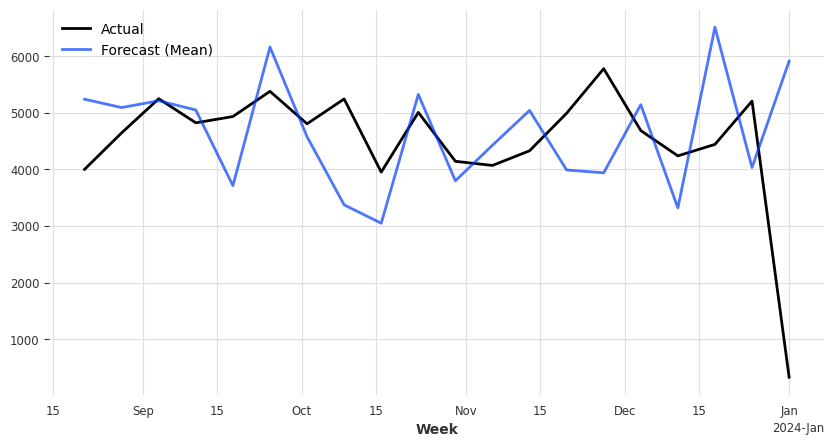

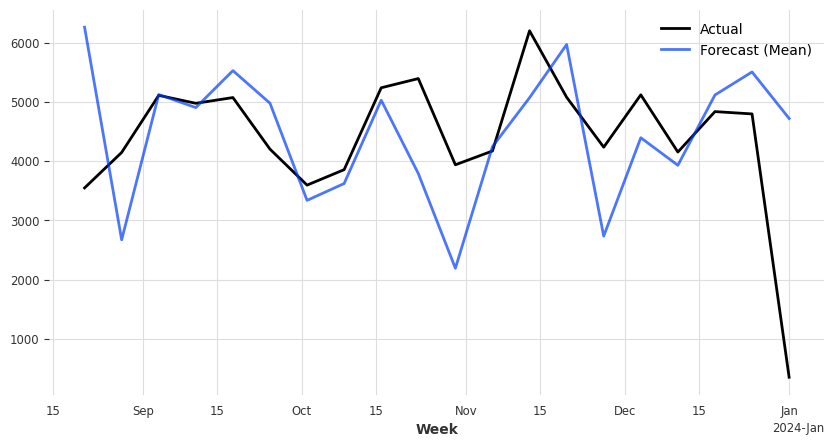

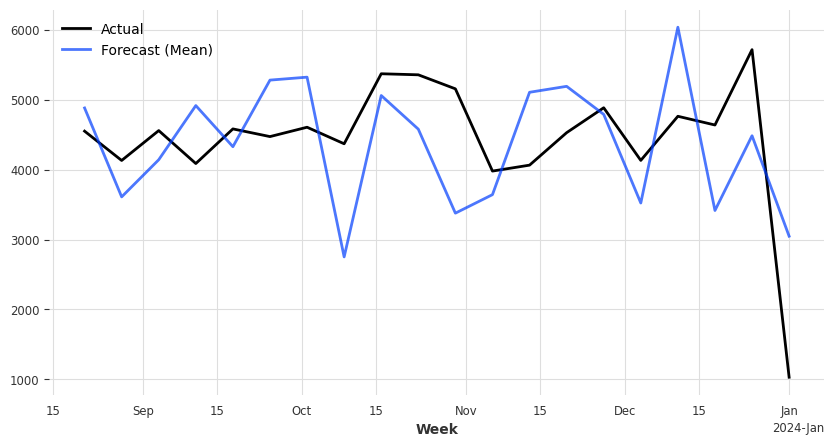

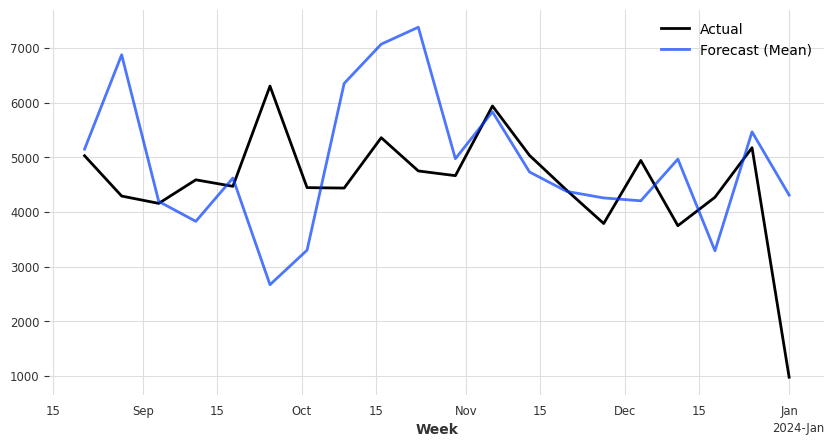

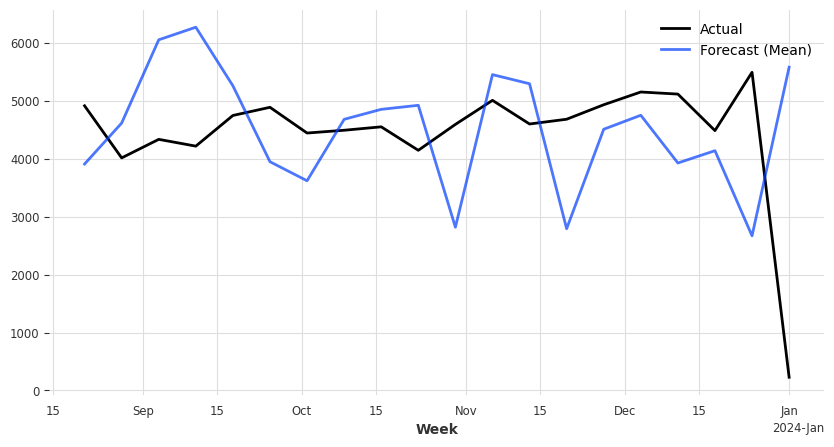

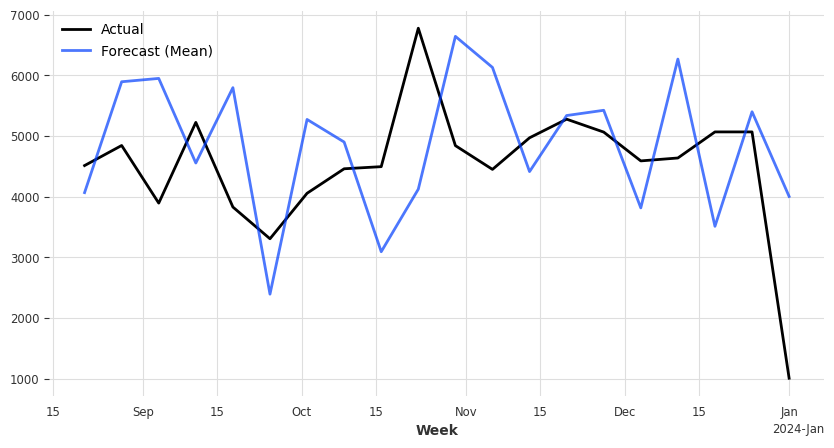

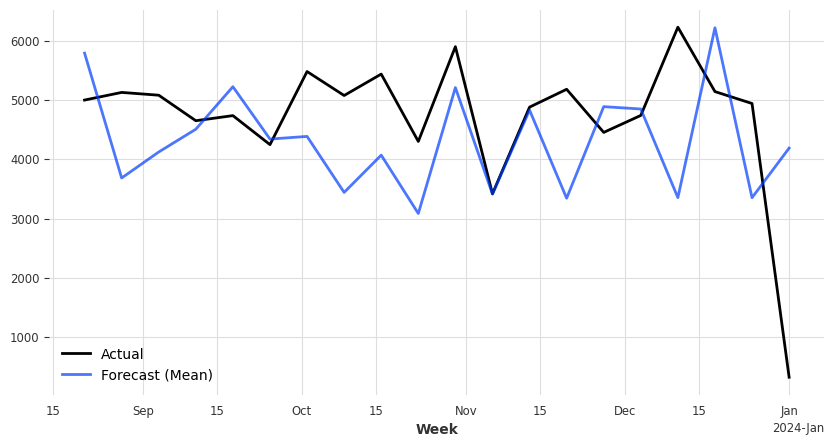

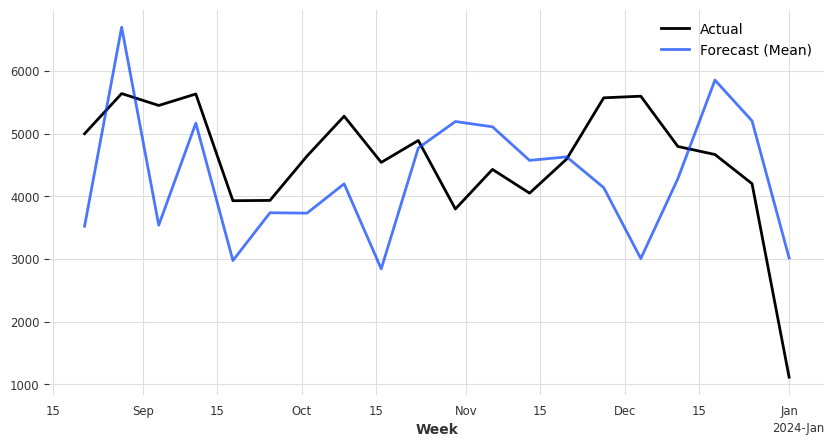

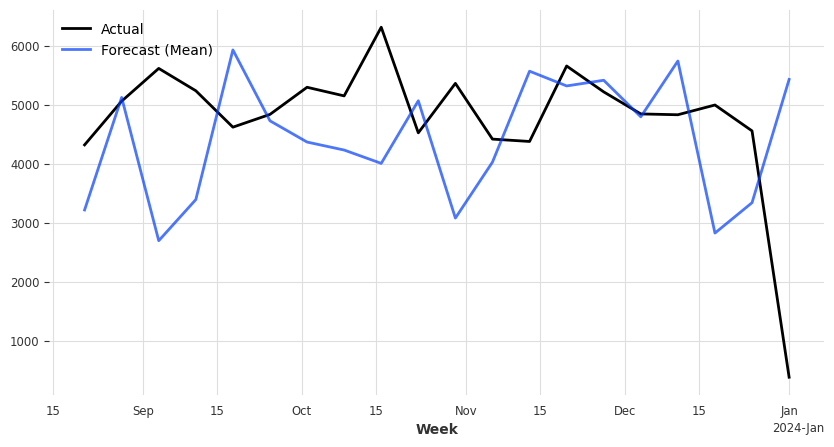

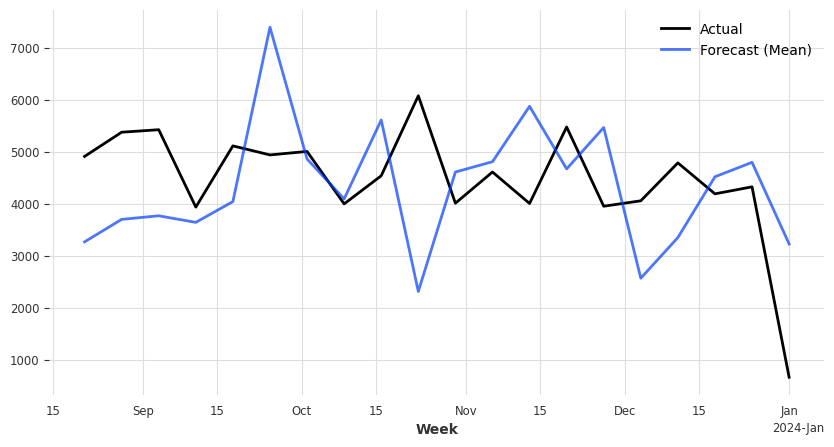

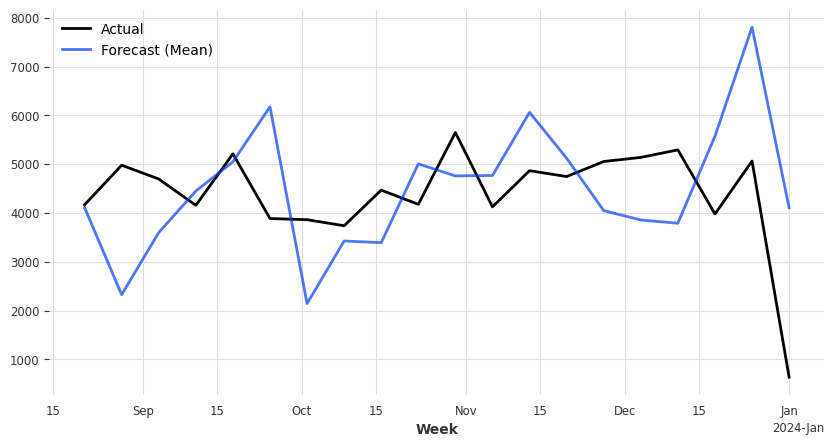

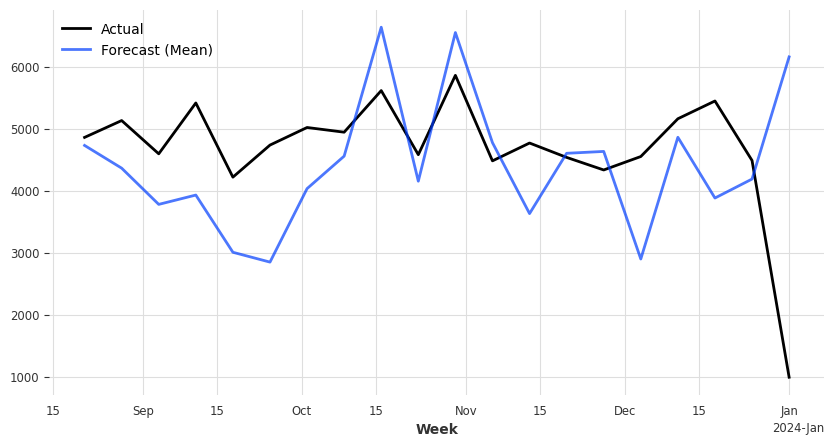

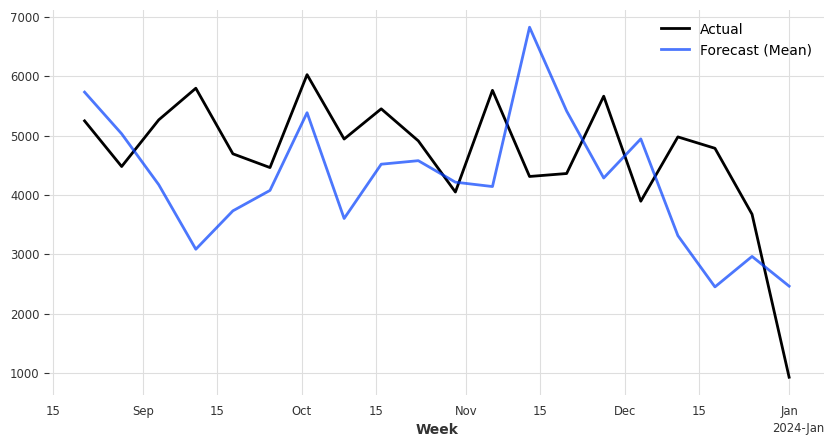

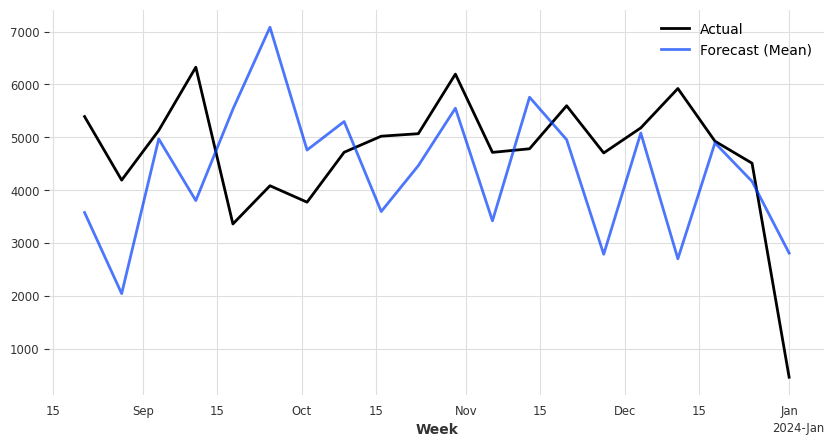

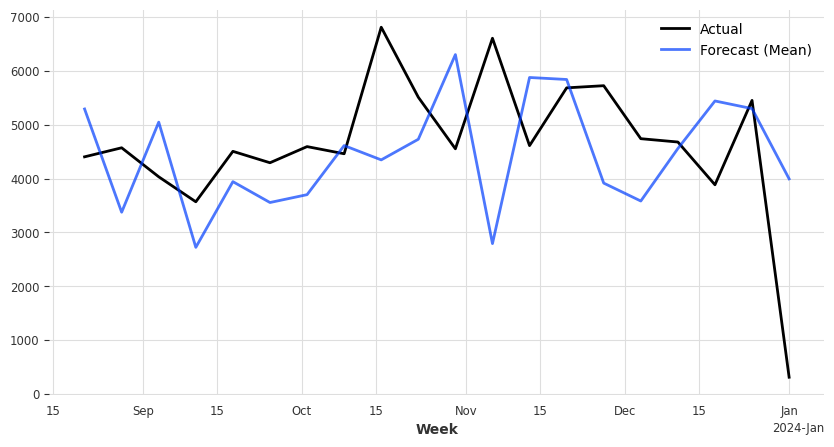

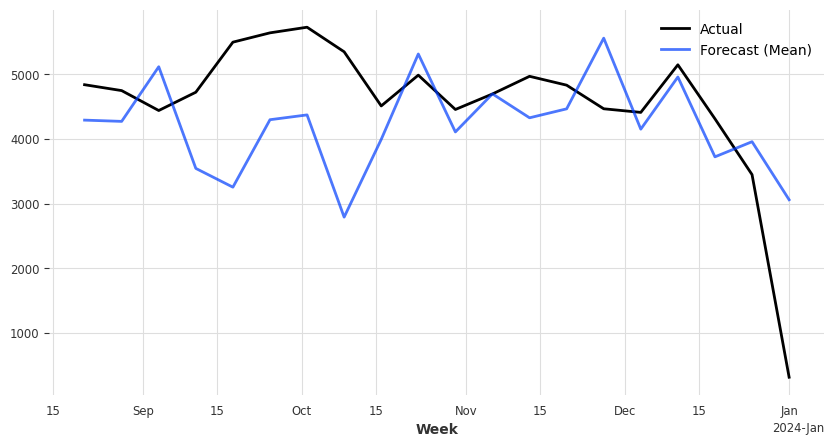

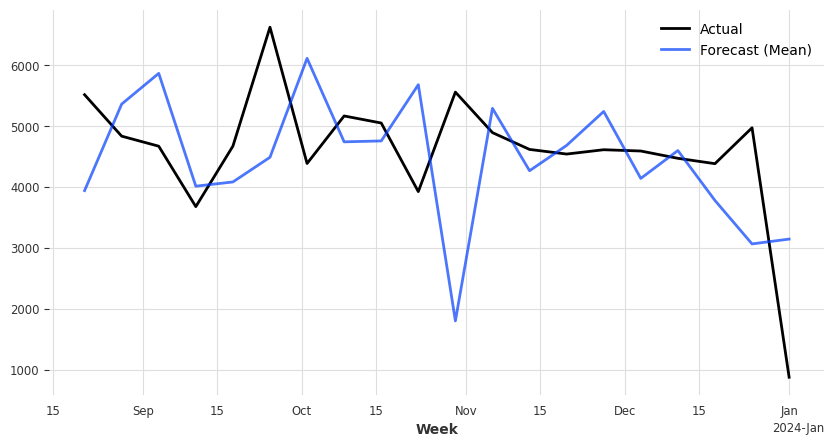

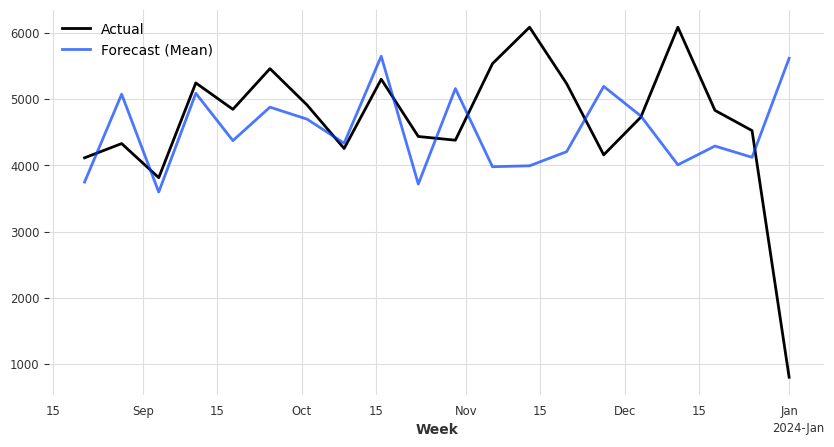

In [17]:
# Plot actual vs predicted
for i, (actual, predicted) in enumerate(zip(test_series_list, predictions_scaled_back)):
    plt.figure(figsize=(10, 5))
    actual.plot(label="Actual", lw=2)
    predicted.plot(label="Forecast (Mean)", lw=2, alpha=0.7)
    # plt.title(f"Product {list(target_series_dict.keys())[i]} - Forecast vs Actual")
    plt.legend()
    plt.show()

### Evaluation

**histotical_forecast**: retrospectively applying the model to different time steps
- Pre-trained Mode (retrain=False): evaluate model’s performance over the entire duration of the series
- Input: full scaled dataset (train + test)
    - to test how the model would behave on unseen data
    - **start** parameter: the first point in time at which a prediction is computed -- train-test split in the same proportion 

Workflow
- Train scaler on training data.
- Forecast on full (scaled) series, starting at the end of training.
- Compare predictions to the corresponding part of the original test set.

How historical_forecasts work? Whether it uses ground truth for prediction?
- Yes, the official documentation states: “the resulting forecasts will use the ground truth data from the past.”
- The source code confirms that it slices the series from the ground-truth input at each forecast step.
- Quick experiments also show it does not use forecasted values for subsequent prediction steps.

overview of input data: 
- model.fit: scaled training data
- historical_forecasts: full dataset (train+test) --> forecast(time range correspond to test)
- evaluation metric: compare forecast and ground truth (both in time range of test dataset)

implementation details
- historical_forecasts accept data_transformers parameter to automatically fit transform on training data, transform test, and inverse transform prediction; we can use the parameter or use our existing datapipeline and model training and eval pipeline (to be built later); suggest which workflow is better 
- context: im building models with Darts, i think historical_forecasts() is implemented for all Darts models? correct me if im wrong. im planning to build multiple darts model to compare and evaluate. take this into consideration when suggesting workflow
- you may suggest how to write the model training and evaluation pipeline as well, remember im doing multivariate time series forecast for multiple time series. if you dont have enough information to build model pipeline (since i dont have hyperparameter implemented for example), just create simple python file for this only model i have to run. 

In [ ]:
# from darts.datasets import AirPassengersDataset
# from darts.models import LinearRegressionModel
# from darts.metrics import mape

# series = AirPassengersDataset().load()[:36]  # shorter series for clarity
# train, test = series[:-6], series[-6:]

# model = LinearRegressionModel(lags=12)
# model.fit(train)

# # Historical forecast
# hist_forecasts = model.historical_forecasts(
#     series,  # full ground-truth series
#     start=0.7,
#     forecast_horizon=2,
#     stride=1,
#     retrain=False,
#     verbose=True
# )

# # Compare predictions with ground truth
# #print(hist_forecasts)
# for t in range(25, 35):
#     forecast_point = series.time_index[t]
#     past = series.drop_after(forecast_point - series.freq)  # past data up to t-1
#     print(f"At forecast point t={t} ({forecast_point.date()}), model sees past data from {past.start_time().date()} to {past.end_time().date()}")

# # If it were using forecasts recursively, you'd see drift or large errors.

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/11 [00:00<?, ?it/s]

At forecast point t=25 (1951-02-01), model sees past data from 1949-01-01 to 1950-12-01
At forecast point t=26 (1951-03-01), model sees past data from 1949-01-01 to 1951-01-01
At forecast point t=27 (1951-04-01), model sees past data from 1949-01-01 to 1951-02-01
At forecast point t=28 (1951-05-01), model sees past data from 1949-01-01 to 1951-03-01
At forecast point t=29 (1951-06-01), model sees past data from 1949-01-01 to 1951-04-01
At forecast point t=30 (1951-07-01), model sees past data from 1949-01-01 to 1951-05-01
At forecast point t=31 (1951-08-01), model sees past data from 1949-01-01 to 1951-06-01
At forecast point t=32 (1951-09-01), model sees past data from 1949-01-01 to 1951-07-01
At forecast point t=33 (1951-10-01), model sees past data from 1949-01-01 to 1951-08-01
At forecast point t=34 (1951-11-01), model sees past data from 1949-01-01 to 1951-09-01


In [ ]:
from darts.metrics import mape, rmse

# Example: predicting 1 month ahead each time, and repeating the prediction over multiple points
forecast_series = model.historical_forecasts(
    series=target_series,
    future_covariates=future_covariates_custom,
    start=0.7,                     # start forecasting after 70% of data (can be tuned)
    forecast_horizon=4,            # predict next month if your horizon=4 weeks or 1 month
    stride=1,                      # roll forward by 1 step each time for dense evaluation
    retrain=False,                 # or True if you want to retrain each time (slower)
    verbose=True
)

# Compare with actual values:
error_mape = mape(target_series, forecast_series)
error_rmse = rmse(target_series, forecast_series)

print(f"MAPE: {error_mape:.2f}%")
print(f"RMSE: {error_rmse:.2f}")

In [ ]:
# ✅ When calling historical_forecasts, also pass the data_transformers dictionary:
forecast_series = model.historical_forecasts(
    series=full_series,
    future_covariates=full_future_covariates,
    start=train.end_time(),
    forecast_horizon=4,
    stride=1,
    retrain=False,
    data_transformers={  # <== correct format!
        "series": series_transformer,
        "future_covariates": future_covariates_transformer
    },
    verbose=True
)

# forecast_series will be inverse-transformed if transformers support it
test_slice = full_series.slice_intersect(forecast_series)

from darts.metrics import mape, rmse
print(f"MAPE on test: {mape(test_slice, forecast_series):.2f}%")
print(f"RMSE on test: {rmse(test_slice, forecast_series):.2f}")